# Titanic Passengers Survival Prediction

The aims of this project is to create a model that predict the survival of titanic passengers. The dataset used in this project has been splitted into two set, the training set and the testing set. Each dataset consist of 891 and 418 samples, respectively. The variables used in this dataset are:

|Variable     |Explanation|
|-------------|-----------|
|PassengerID   | Passenger ID|
|Survived      | Passenger Survival (0 = didn't survive, 1 = survive)|
|Pclass        | Passenger Class|
|Name          | Passenger Name|
|Sex           | Passenger Sex|
|Age           | Passenger Age|
|SibSp         | How many siblings and spouses of the passenger abroad the Titanic|
|Parch         | How many parents and children of the passenger abroad the Titanic|
|Ticket        | Ticket ID|
|Fare          | Passenger Fare (in Poundsterling)|
|Cabin         | Cabin Number|
|Embarked      | Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)|

Import libraries

In [1]:
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

sns.set_style("whitegrid", {"axes.grid" : False})
sns.set_context("notebook", font_scale=1.2)
sns.set_palette("muted")

Load the data

In [2]:
training_set  = pd.read_csv("dataset/train.csv")
testing_set = pd.read_csv("dataset/test.csv")

Shows the first three rows of the training set and the testing set

In [3]:
training_set.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
testing_set.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


## Data Summarization


Shows the summary of the data

In [5]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


It can be seen that there's colums with missing values in this dataset, and not all columns is in numeric values

Describe the training set

In [6]:
training_set.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Sum the missing values in the training set and the testing set

In [7]:
training_set.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
testing_set.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

We can see that the Cabin column has to many missing values, so we will drop this column later

Check the correlation of each columns

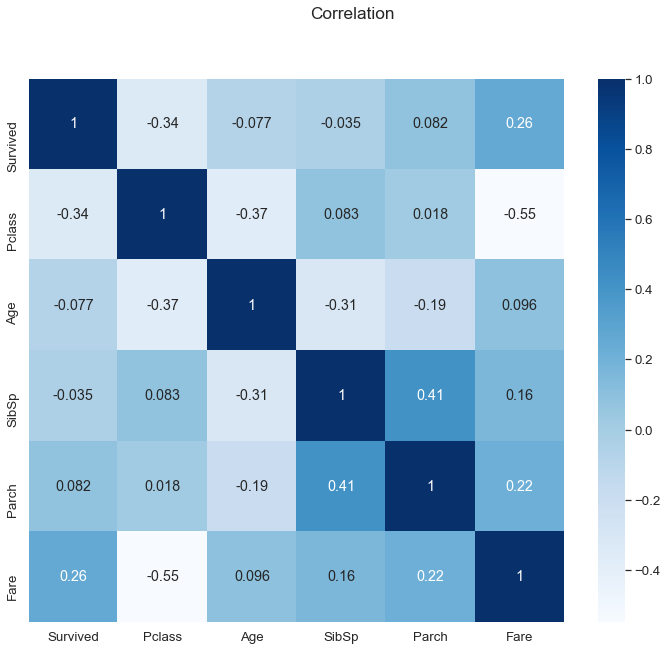

In [9]:
plt.figure(figsize=[12, 10])
plt.suptitle("Correlation")
sns.heatmap(training_set[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].corr(), annot=True, cmap="Blues");

Plot the passenger count and survival rate by sex

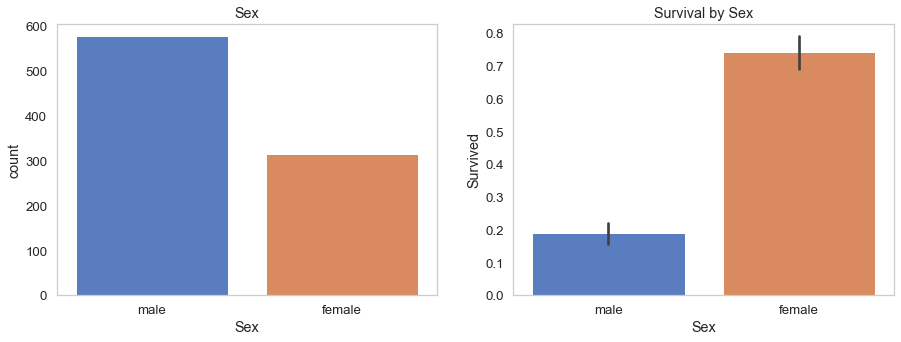

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(ax=axes[0], x="Sex", data=training_set)
axes[0].set_title("Sex")

sns.barplot(ax=axes[1], x="Sex", y="Survived", data=training_set)
axes[1].set_title("Survival by Sex");

Plot the passenger count and survival rate by PClass

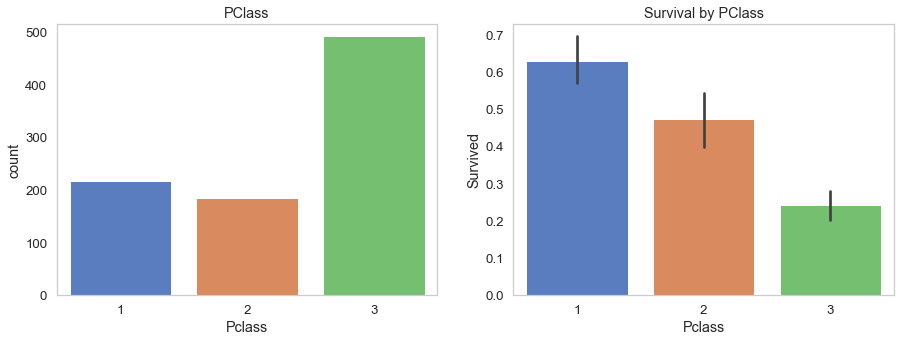

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(ax=axes[0], x="Pclass", data=training_set)
axes[0].set_title("PClass")

sns.barplot(x="Pclass", y="Survived", data=training_set);
axes[1].set_title("Survival by PClass");

Plot the passenger count and survival rate by port of embarkation

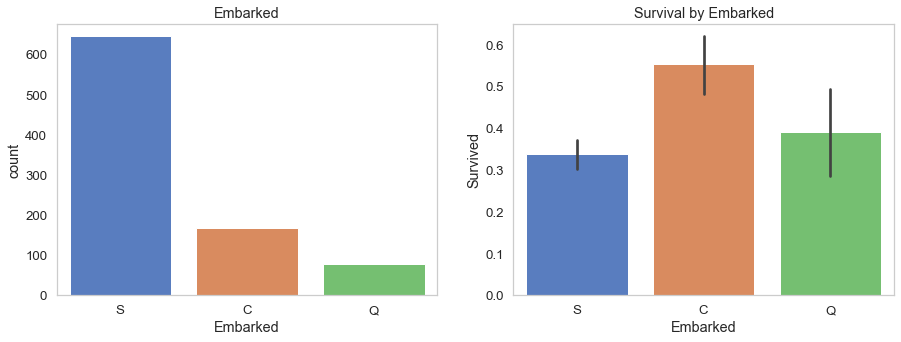

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(ax=axes[0], x="Embarked", data=training_set)
axes[0].set_title("Embarked")

sns.barplot(x="Embarked", y="Survived", data=training_set);
axes[1].set_title("Survival by Embarked");

## Data Preparation

Create a copy of the training set and the testing set before we do the data preprocessing step

In [13]:
training_set_copy = training_set.copy()
testing_set_copy = testing_set.copy()

Impute the embarked column. Here we are imputing based on the label that appears most often in the column, namely 'S'

In [14]:
training_set_copy["Embarked"].fillna("S", inplace=True)

Impute the age and the fare column using KNN Imputer. We don't impute the fare column in the testing set because there's no missing values there

In [15]:
imputer = KNNImputer(n_neighbors=3)
training_set_copy["Age"] = imputer.fit_transform(training_set_copy[["Age"]]).ravel()
testing_set_copy["Age"] = imputer.fit_transform(testing_set_copy[["Age"]]).ravel()
testing_set_copy["Fare"] = imputer.fit_transform(testing_set_copy[["Fare"]]).ravel()

Drop the Cabin because it has too many missing values, also drop the passengerID, Name and Ticket column because it doesn't provide meaningful information for our model

In [16]:
drop_column = ["PassengerId", "Name", "Cabin", "Ticket"]
training_set_copy = training_set_copy.drop(drop_column, axis=1)
testing_set_copy = testing_set_copy.drop(drop_column, axis=1)

Check the training set and the testing set after data imputation

In [17]:
training_set_copy.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [18]:
testing_set_copy.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [19]:
training_set_copy.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Encode categorical columns using Label Encoder

In [20]:
label_encoder = LabelEncoder()
label = ["Sex", "Embarked"]
training_set_copy[label] = training_set_copy[label].apply(label_encoder.fit_transform)
testing_set_copy[label] = testing_set[label].apply(label_encoder.fit_transform)

Split the features and target variable

In [21]:
X_train = training_set_copy.drop(["Survived"], axis=1)
y_train = pd.DataFrame(training_set_copy["Survived"].copy())
X_test = testing_set_copy

Scale the data using Standard Scaler

In [22]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Model Training

Model shortlisting by creating a multiple model with default hyperparameter

In [23]:
models = [
    ("Logistic Regression", LogisticRegression()),
    ("KNN", KNeighborsClassifier()),
    ("Naive Bayesian", GaussianNB()),
    ("Support Vector Machine", SVC()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier())]

names = []
cv_mean = []
cv_std = []
scoring = "accuracy"
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train.values.ravel(), cv=kfold, scoring=scoring)
    names.append(name)
    cv_mean.append(cv_results.mean())
    cv_std.append(cv_results.std())

model_results = pd.DataFrame(list(zip(names, cv_mean, cv_std)), columns=['model', 'accuracy', 'stdev'])
model_results.round(3)

,model,accuracy,stdev
0,Logistic Regression,0.792,0.029
1,KNN,0.798,0.032
2,Naive Bayesian,0.789,0.023
3,Support Vector Machine,0.826,0.044
4,Decision Tree,0.772,0.033
5,Random Forest,0.816,0.032


The results shows that the Support Vector Machine (SVM) model achieve the highest accuracy compared to other algorithm. So, now we going to fine tune the SVM model to get a better result

## Fine Tuning

Fine tuning SVM model using Randomized Search CV

In [24]:
clf = SVC()

rand_list = {"C": stats.uniform(2, 10),
             "gamma": stats.uniform(0.1, 1)}
              
rand_search = RandomizedSearchCV(clf, param_distributions = rand_list, n_iter = 20, n_jobs = 4, cv = 10, random_state = 42, scoring = "accuracy") 
rand_search.fit(X_train, y_train.values.ravel()) 
print(f"best parameter: {rand_search.best_params_}")

best parameter: {'C': 5.046137691733707, 'gamma': 0.19767211400638388}


Predict the training set using new fine-tuned model

In [25]:
y_train_predicted = rand_search.predict(X_train)

Generate the classification report

In [26]:
clf_report = classification_report(y_train, y_train_predicted)
print(clf_report)

              precision    recall  f1-score   support

           0       0.84      0.96      0.89       549
           1       0.91      0.70      0.79       342

    accuracy                           0.86       891
   macro avg       0.88      0.83      0.84       891
weighted avg       0.87      0.86      0.86       891



Plot the confusion matrix

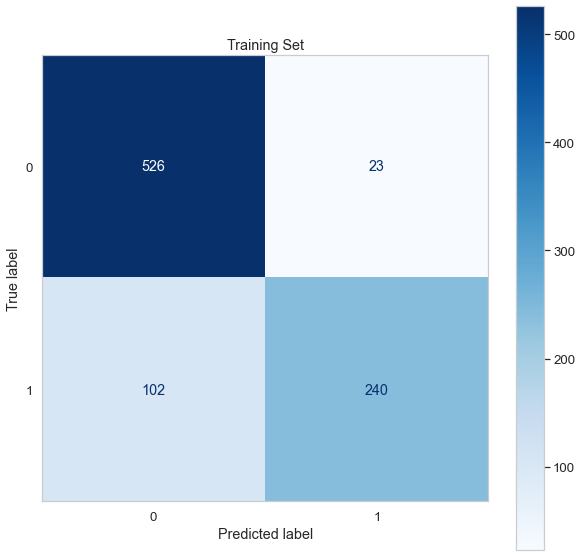

In [27]:
conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_predicted))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Training Set')
conf_mat.plot(cmap=plt.cm.Blues, ax=ax);

Predict the test set

In [28]:
y_test_predicted = rand_search.predict(X_test)
y_test_predicted = pd.DataFrame(y_test_predicted, columns=["Survived"])
y_test_predicted.head(10)

,Survived
0,0
1,0
2,0
3,0
4,0
5,0
6,1
7,0
8,1
9,0


Create a dataframe that merged the test dataset with predicted label

In [29]:
test_predicted_merged = pd.concat([testing_set_copy, y_test_predicted], axis=1)
test_predicted_merged

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,34.50000,0,0,7.8292,1,0
1,3,0,47.00000,1,0,7.0000,2,0
2,2,1,62.00000,0,0,9.6875,1,0
3,3,1,27.00000,0,0,8.6625,2,0
4,3,0,22.00000,1,1,12.2875,2,0
...,...,...,...,...,...,...,...,...
413,3,1,30.27259,0,0,8.0500,2,0
414,1,0,39.00000,0,0,108.9000,0,1
415,3,1,38.50000,0,0,7.2500,2,0
416,3,1,30.27259,0,0,8.0500,2,0


Save the merged test set as csv

In [30]:
test_predicted_merged.to_csv('dataset/test_predicted.csv')

## Save the final model

In [31]:
filename = "model/titanic_survival_model.sav"
joblib.dump(model, filename)

['model/titanic_survival_model.sav']

## Conclusion

We have finished building a classification model capable of making survival predictions for the titanic passenger. After shortlisting several models, it is known that the SVM model can provide more accurate accuracy compared to other models, by using the default hyperparameters in the scikit-learn library. After fine-tuning, we managed to improve the performance of the model with an accuracy of 86%. This shows that our model can provide an accurate prediction.